# **Text Summarization System**

**Neural Network and Deep Learning (COMP 488)**

**Mini Project**

In [40]:
!pip install openpyxl  --quiet

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [42]:
import re
import os
import time

In [43]:
from collections import defaultdict
import string
import seaborn as sns

In [44]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [45]:
ENCODER_LEN = 100
DECODER_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE * 8

In [46]:
num_layers = 3
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.2
EPOCHS = 15

In [47]:
news = pd.read_excel("/kaggle/input/dataset-mini-project-comp488/data.xlsx",engine = 'openpyxl')
news.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [48]:
article = news['Short']
summary = news['Headline']

In [49]:
article = article.apply(lambda x: '<SOS> ' + x + ' <EOS>')
summary = summary.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [50]:
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text

In [51]:
article = article.apply(lambda x: preprocess(x))
summary = summary.apply(lambda x: preprocess(x))

In [52]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)

inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

In [53]:
ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1

In [54]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)

In [55]:
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
targets = tf.cast(targets, dtype=tf.int64)

In [56]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [57]:
def calculate_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [58]:
def generate_positional_encoding(position, d_model):
    angle_rads = calculate_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [59]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [60]:
def generate_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [61]:
def compute_scaled_dot_product(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [62]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = compute_scaled_dot_product(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

In [63]:
def built_pointwise_feedforward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [64]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = built_pointwise_feedforward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [65]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = built_pointwise_feedforward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [66]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = generate_positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = generate_positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights
    

In [67]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [68]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return (tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2))

In [69]:
learning_rate = CustomSchedule(d_model)

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

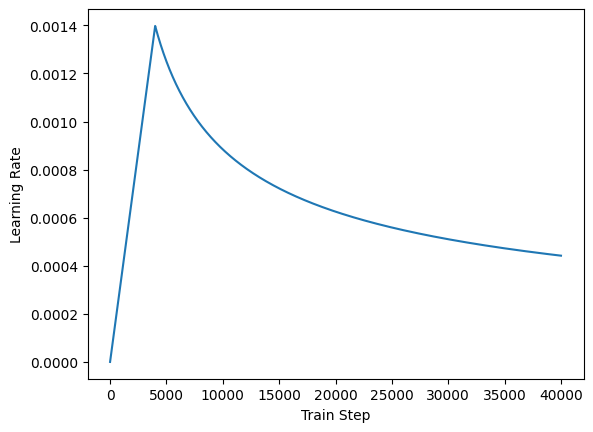

In [71]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [72]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [73]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [74]:
def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [75]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [76]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [77]:
def generate_masks(inp, tar):
    enc_padding_mask = generate_padding_mask(inp)
    dec_padding_mask = generate_padding_mask(inp)

    look_ahead_mask = generate_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = generate_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [78]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')